In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ, BasicAer
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
def ransom(qc, bitchain, qkey):
    for bit in range(0,len(bitchain)):
        if(bitchain[bit] == '1'):
            qc.x(bit)
        if(qkey[2*bit] == '1'):
            qc.z(bit)
        if(qkey[2*bit+1] == '1'):
            qc.x(bit)
    return qc

def unransom(qc, cypherchain, qkey):
    for bit in range(0,cypherchain):
        if(qkey[2*bit] == '1'):
            qc.z(bit)
        if(qkey[2*bit+1] == '1'):
            qc.x(bit)
    return qc

def quantum_random_key(length,backend):
    qkey = ''
    for i in range(0,2*length):
        qc = QuantumCircuit(1,1)
        qc.h(0)
        qc.measure(0,0)
        counts = execute(qc, backend=backend, shots=1).result().get_counts(qc)
        qkey += list(counts.keys())[0]
    return qkey

def execute_circuit(qc,backend):
    job = execute(qc, backend, shots=100)
    result = job.result()
    return result.get_counts(qc)

In [3]:
message= "Y"
print("Alice message to Bob is: " + message)
def toBinary(a):
  l,m=[],[]
  for i in a:
    l.append(ord(i))
  for i in l:
    m.append(int(bin(i)[2:]))
  return m


x= toBinary(message)
print(message + " in binary is => " + str(x)) 

txt=''.join(map(str, x))
binaryString= txt[::-1]

print("Sending "+ txt + " to quantum circuit")




Alice message to Bob is: Y
Y in binary is => [1011001]
Sending 1011001 to quantum circuit


The quantum key for decrypting the files is: 0000110100010000 (Bob does not know this)
Eve's ransomware is embedded in the following circuit


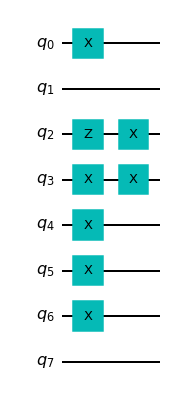

In [4]:
#Preparation of malicious quantum oracle. This will serve/execute a ransomware attack which will encrypt the original 
#message sent by Alice. It can be decrypted only with the key that is generated under a 
#Quantum Random String Generator function with the size equal to the length of the message

initialString = binaryString
backend = BasicAer.get_backend('qasm_simulator')
qkey = quantum_random_key(len(initialString)+1,backend)
print("The quantum key for decrypting the files is: " + qkey + " (Bob does not know this)") #Bob doesnt know this
encrypt = QuantumCircuit(len(initialString)+1, name = '2) Malware Vector: Data Encrypt')
ransom(encrypt,initialString,qkey)
print ("Eve's ransomware is embedded in the following circuit")
blackbox= encrypt.to_gate()
encrypt.draw(output='mpl', filename='ransomware.png')

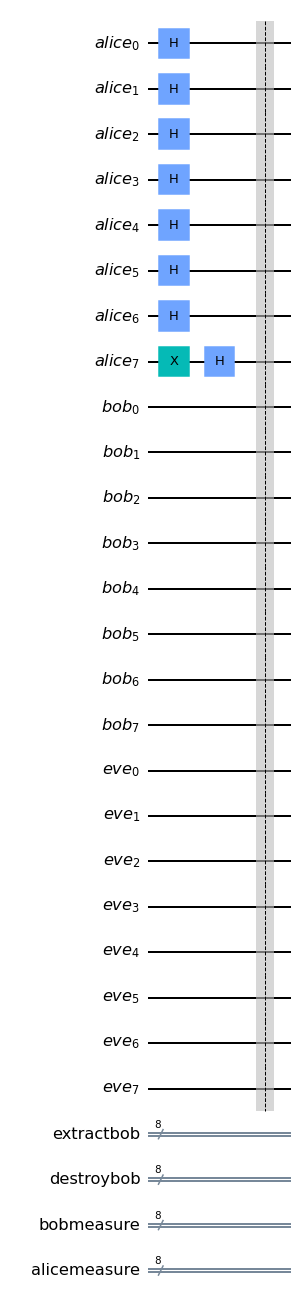

In [5]:
Alice = QuantumRegister(len(initialString)+1,'alice') # Alice's Quantum Register
Bob = QuantumRegister(len(initialString)+1,'bob') # Bob's Quantum Register
Eve = QuantumRegister(len(initialString)+1, 'eve') # Eve's (attacker) Quantum Register

# Initializing classical registers, we need 4: 
# 1) Extractbob register will measure the data exfiltrated from Bob's register. This is owned by the attacker
# 2) DestroyBob register will introduce a measurement to collapse Bob's system with the deployed ransomware.
# This is a measure done from the attacker's perspective compromising Bob's endpoint.
# 3) BobMeasure is the actual measure Bob will do. It is expected to be the same measure as DestroyBob since
# we know in advance the attacker will tamper his system with the malware execution.
#4) For extra reference we include Alice register. Since she intends to pass a message to Bob its measurement 
#should be always 0.

ccr = ClassicalRegister(len(initialString)+1,'destroybob') 
ccr2 = ClassicalRegister(len(initialString)+1,'extractbob')
ccr3= ClassicalRegister(len(initialString)+1,'bobmeasure')
ccr4 = ClassicalRegister(len(initialString)+1,'alicemeasure')
    
circuit = QuantumCircuit() # quantum circuit (initially empty)
circuit.add_register(Alice) # add Alice's quantum register to the quantum circuit
circuit.add_register(Bob) # add Bob's quantum register to the quantum circuit
circuit.add_register(Eve) # add attacker's quantum register to the quantum circuit

#Add classical registers
circuit.add_register(ccr2)
circuit.add_register(ccr)
circuit.add_register(ccr3)
circuit.add_register(ccr4)


#Alice begins placing her quantum registers in the logical pattern she needs for sending her message to Bob
#For this, she needs to create a simple oracle function; she begins by placing n-1 
#qubits in superposition which number determined by the length of the binarystring. Next, she applies a NOT
#operation followed by a Hadamard gate to conclude the first part of the oracle function.

circuit.h(range(len(initialString)))
circuit.x(len(initialString))
circuit.h(len(initialString))

circuit.barrier()
circuit.draw(output="mpl")

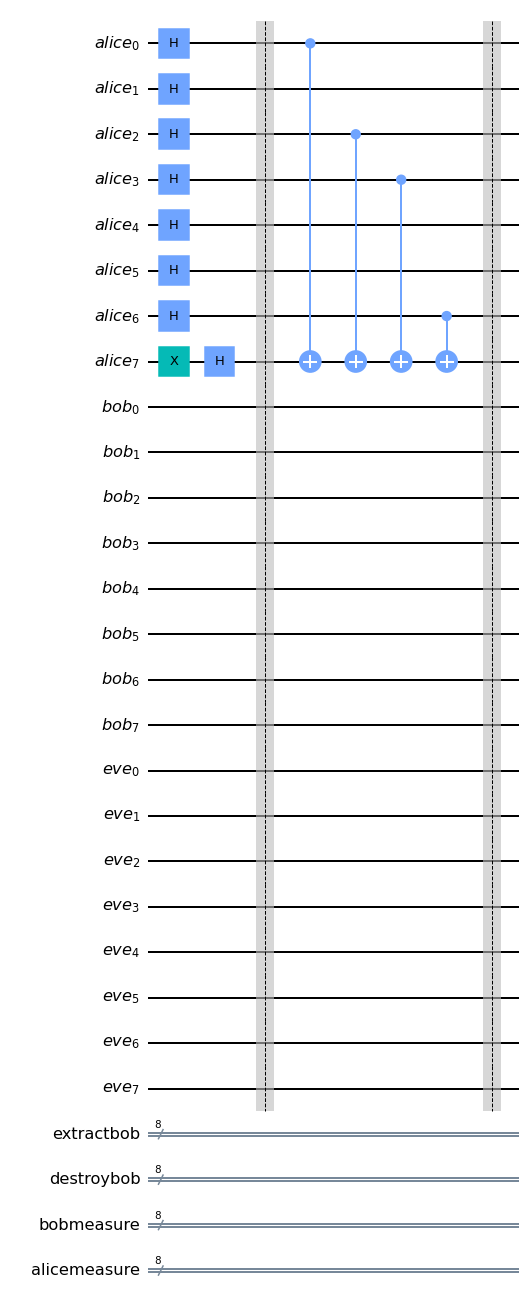

In [6]:
#Next, she applies a control-NOT operation weather it finds a 1 in the binarystring and targets the last 
#qubit of its register array.

for  i,j in enumerate(reversed(initialString)):
    if j == '1':
        circuit.cx(i,len(initialString))
circuit.barrier()
circuit.draw(output="mpl")

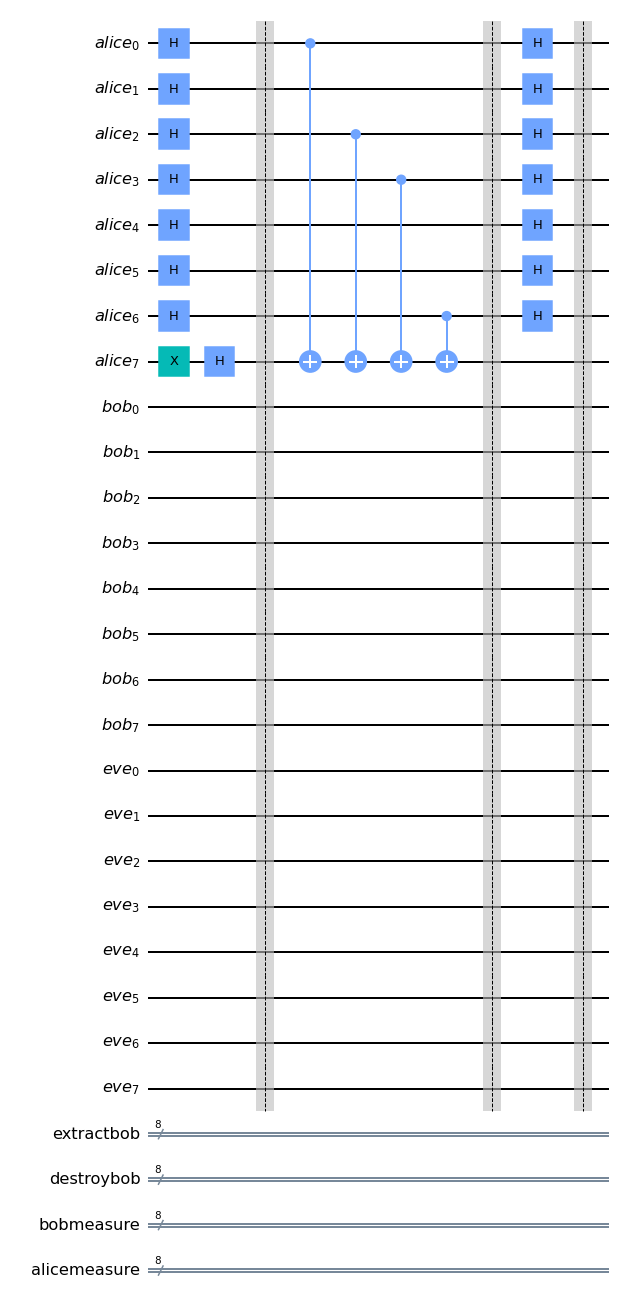

In [7]:
#Finally, she applies a Hadamard gate to her n-1 qubits and prepares to apply a SWAP gate 
#to actually send her registers to Bob (communication stage), while Bob is just waiting.

circuit.h(range(len(initialString)))
circuit.barrier()
circuit.draw(output='mpl', filename='alicemessage.png')

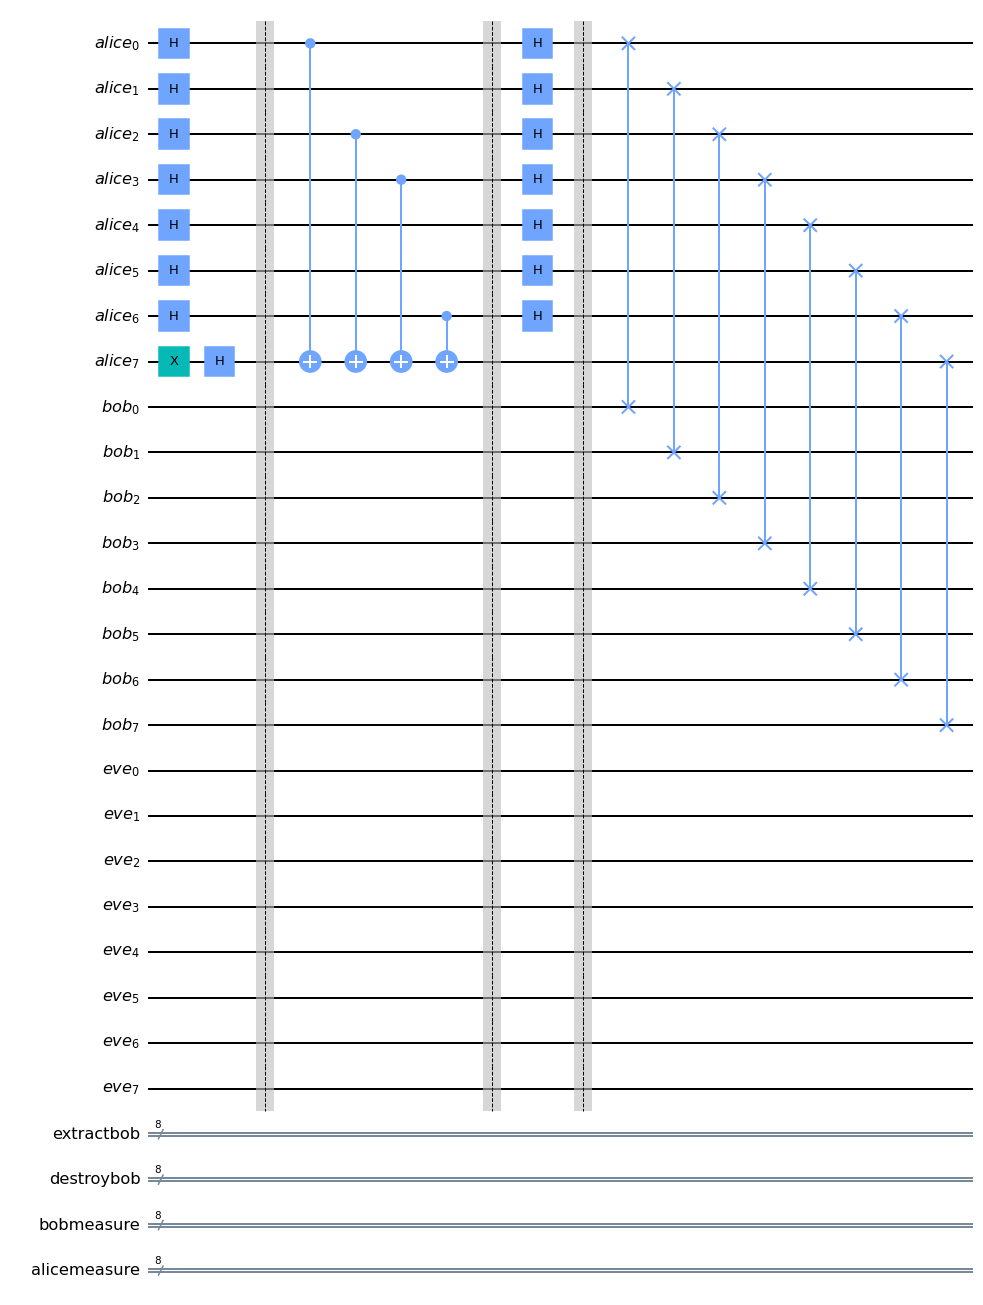

In [8]:
circuit.swap(Alice,Bob)
circuit.draw(output='mpl', filename="alicemessage2.png")

[8, 9, 10, 11, 12, 13, 14, 15]
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


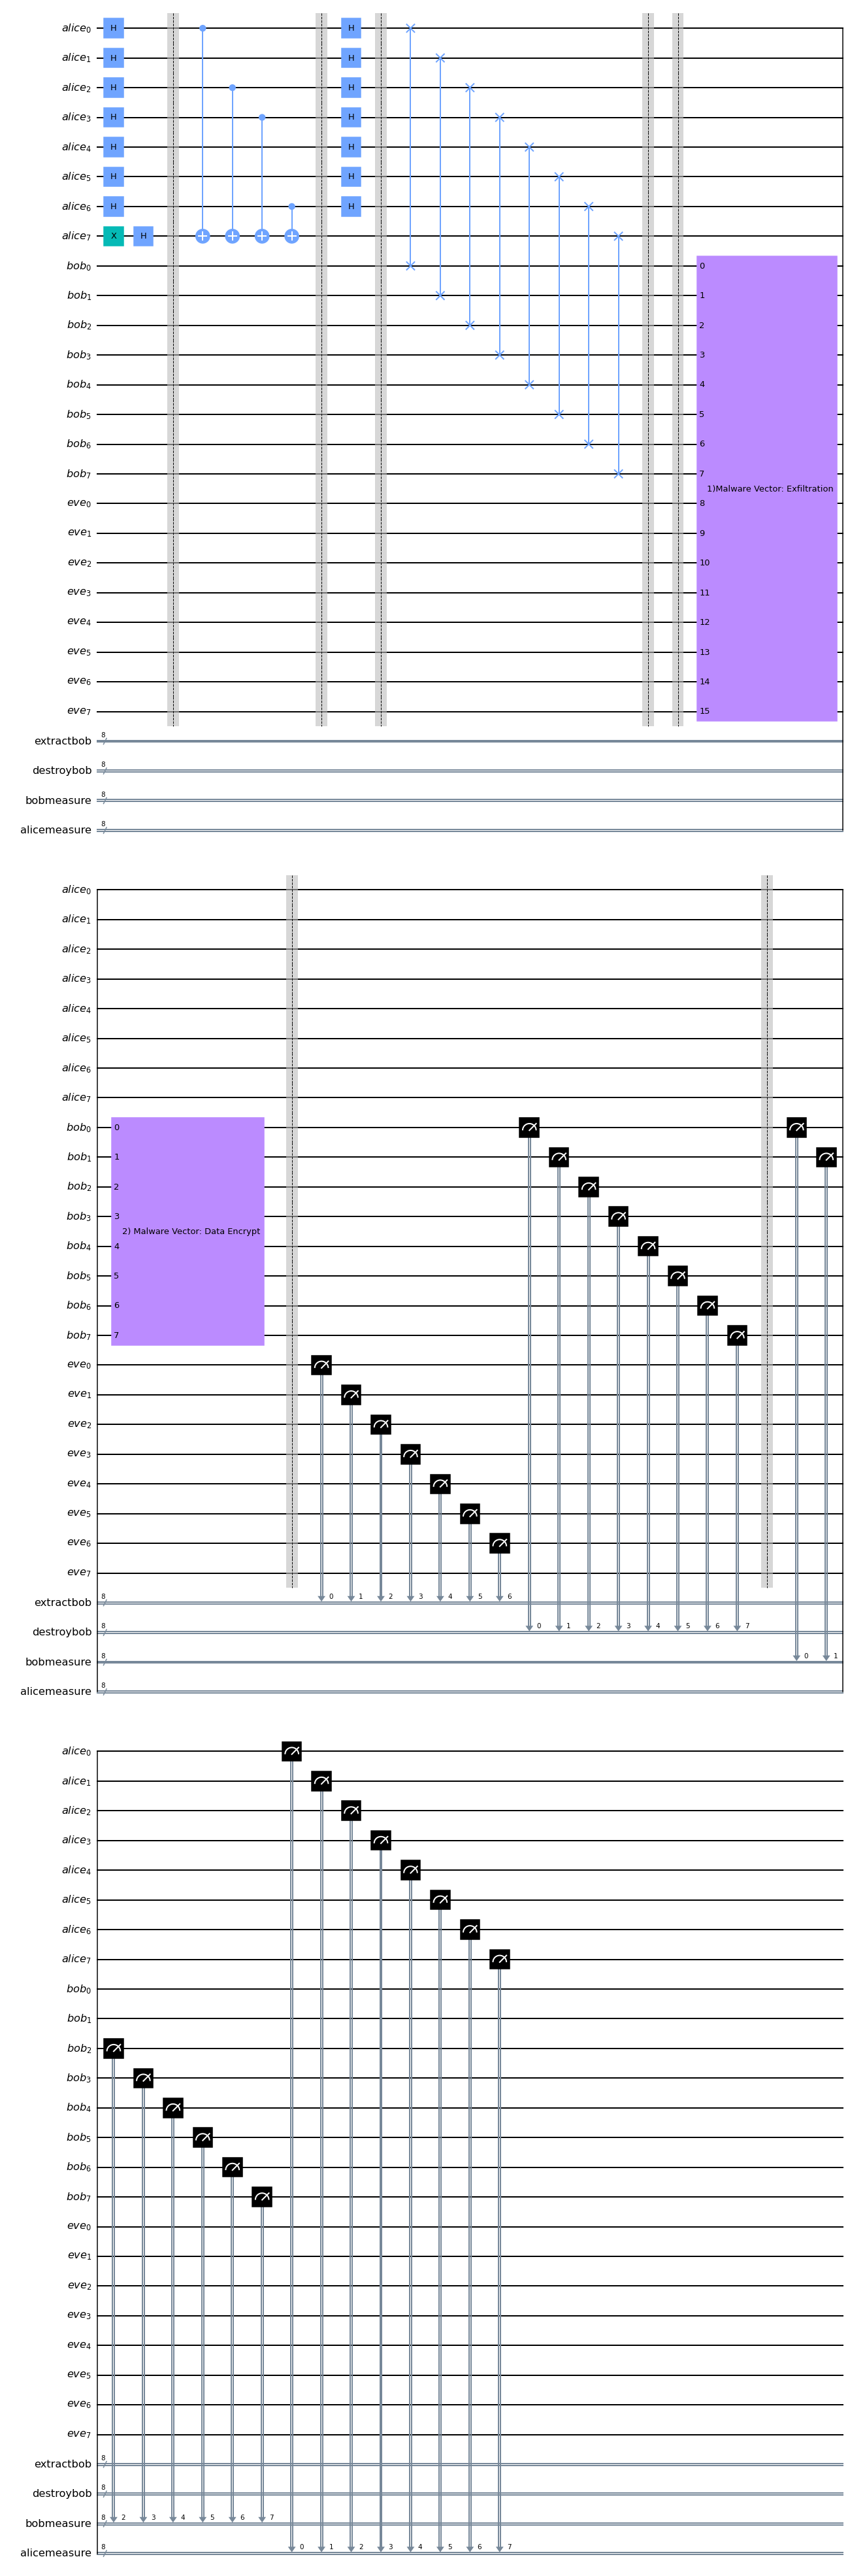

In [9]:
#Bob only needs to measure his registers to receive Alice communication, but what
#he does not know is that his system is already compromised by a quantum malware deployed by Eve on his end.


#Quantum Malware deploy. This vector involves two tactics: Exfiltration and Impact, using techniques
#Exfiltration Over a Quantum Channel and Data Encrypted for Impact respectively.
circuit.barrier()

extraction = QuantumCircuit(name='1)Malware Vector: Exfiltration')

extraction.add_register(Bob)
extraction.add_register(Eve)
extraction.cx(Bob,Eve)
extraction.cx(Eve,Bob)
extraction.cx(Bob,Eve)

extr_gate = extraction.to_gate()

#circuit.cx(Bob,Eve) 
#circuit.cx(Eve,Bob)
#circuit.cx(Bob,Eve)
circuit.barrier()


#Uploading quantum ransomware, composed by two quantum circuits with its respective operations to extract
#and encrypt
L = [x for x in range(len(initialString)+1, (len(initialString)+1)*2)]
N = [y for y in range(len(initialString)+1, (len(initialString)+1)*3)]   
print(L)
print(N)

b = circuit.compose(extr_gate,N)
a= b.compose(blackbox,L)
a.barrier()


a.measure(Eve[0:len(initialString)],ccr2[0:len(initialString)]) #Measure of the qubits extracted by the quantum malware
a.measure(Bob,ccr[0:len(initialString)+1]) #Destruccion of Bob channel (Ransomware attack)
a.barrier()
a.measure(Bob,ccr3) #Actual Bob measure. In his measure he will observe the ransomware
a.measure(Alice, ccr4) # Alice measure
    

a.draw(output='mpl', filename='final_circuit.png')

{'00000000 01110101 01110101 01001101': 1024}


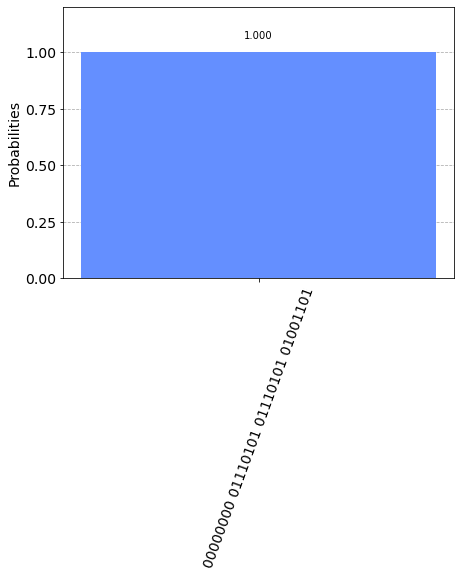

In [10]:
simulator = Aer.get_backend('qasm_simulator')
result= execute(a, simulator, shots= 1024).result().get_counts()
print(result)
#The final measure reveals the result of our attack. The first group of LSB's tell us the attack 
#was successful as this is the attacker's register containing the extracted message (man in the endpoint)
# The next two groups are refering to Bob's register which is now tampered with the Quantum Ransomware 
# and if he wants to recover his information, he needs the key for decrypting the oracle
# The final group is Alice's register which is 0 since she passed the message to Bob.
plot_histogram(result)

The encrypted string by the ransomware is: {'1110101': 100}
The original string is: {'1011001': 100}


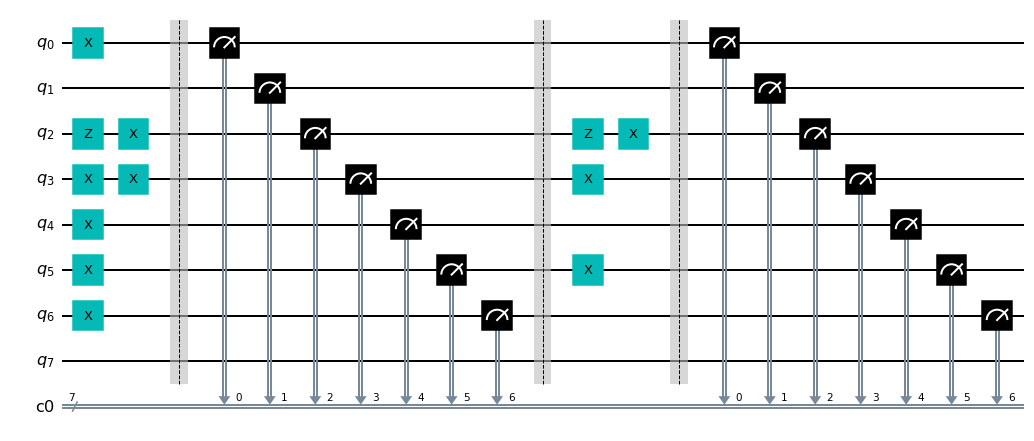

In [11]:
encrypt.add_register(ClassicalRegister(len(initialString)))
encrypt.barrier()
encrypt.measure(range(0,len(initialString)),range(0,len(initialString)))

print("The encrypted string by the ransomware is: " + str(execute_circuit(encrypt,backend)))
encrypt.barrier()

unransom(encrypt,len(encrypt.qubits),qkey)

encrypt.barrier()

encrypt.measure(range(0,len(initialString)),range(0,len(initialString)))

print("The original string is: " + str(execute_circuit(encrypt,backend)))
encrypt.draw(output='mpl', filename="finaldecryption.png")